<a href="https://colab.research.google.com/github/omarehab2110/Hospital-Readmission-Prediction/blob/main/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import joblib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import subprocess
import re
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve


#Reading and Describing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_Of_Diabetic_Data=pd.read_csv('/content/drive/MyDrive/diabetic_data.csv')
# Read specific sections of the CSV file
admission_type_mapping = pd.read_csv('/content/drive/MyDrive/IDs_mapping.csv', nrows=9, names=['id', 'description'])

# Skip to discharge_disposition_id section (lines 11-40 in the file)
discharge_disposition_mapping = pd.read_csv('/content/drive/MyDrive/IDs_mapping.csv', skiprows=10, nrows=30, names=['id', 'description'])

# Skip to admission_source_id section (lines 42-67 in the file)
admission_source_mapping = pd.read_csv('/content/drive/MyDrive/IDs_mapping.csv', skiprows=41, nrows=26, names=['id', 'description'])


###Mapping

In [4]:
# --- Step 1: Read mapping files and prepare 'id' column ---
admission_type_mapping['id'] = admission_type_mapping['id'].str.strip()

discharge_disposition_mapping['id'] = discharge_disposition_mapping['id'].str.strip()

admission_source_mapping['id'] = admission_source_mapping['id'].str.strip()

# --- Step 2: Prepare ID columns in the main DataFrame ---
# Treat ID columns in df_Of_Diabetic_Data as string and strip whitespace
df_Of_Diabetic_Data['admission_type_id_str'] = df_Of_Diabetic_Data['admission_type_id'].astype(str).str.strip()
df_Of_Diabetic_Data['discharge_disposition_id_str'] = df_Of_Diabetic_Data['discharge_disposition_id'].astype(str).str.strip()
df_Of_Diabetic_Data['admission_source_id_str'] = df_Of_Diabetic_Data['admission_source_id'].astype(str).str.strip()

# --- Step 3: Attempt to convert stripped string IDs to integers for mapping ---
# Use a try-except block for robust conversion
try:
    admission_type_mapping['id_int'] = admission_type_mapping['id'].astype(int)
    discharge_disposition_mapping['id_int'] = discharge_disposition_mapping['id'].astype(int)
    admission_source_mapping['id_int'] = admission_source_mapping['id'].astype(int)

    df_Of_Diabetic_Data['admission_type_id_int'] = df_Of_Diabetic_Data['admission_type_id_str'].astype(int)
    df_Of_Diabetic_Data['discharge_disposition_id_int'] = df_Of_Diabetic_Data['discharge_disposition_id_str'].astype(int)
    df_Of_Diabetic_Data['admission_source_id_int'] = df_Of_Diabetic_Data['admission_source_id_str'].astype(int)

    # Use the integer columns for mapping
    map_admission_type = admission_type_mapping.set_index('id_int')['description']
    map_discharge_disposition = discharge_disposition_mapping.set_index('id_int')['description']
    map_admission_source = admission_source_mapping.set_index('id_int')['description']

    # --- Step 4: Perform the mapping ---
    df_Of_Diabetic_Data['admission_type'] = df_Of_Diabetic_Data['admission_type_id_int'].map(map_admission_type)
    df_Of_Diabetic_Data['discharge_disposition'] = df_Of_Diabetic_Data['discharge_disposition_id_int'].map(map_discharge_disposition)
    df_Of_Diabetic_Data['admission_source'] = df_Of_Diabetic_Data['admission_source_id_int'].map(map_admission_source)

    print("Mapping performed using integer IDs.")

except ValueError as e:
    print(f"Could not convert stripped string IDs to integer. Falling back to string mapping. Error: {e}")

    # Fallback to mapping using stripped string IDs if integer conversion fails
    map_admission_type = admission_type_mapping.set_index('id')['description']
    map_discharge_disposition = discharge_disposition_mapping.set_index('id')['description']
    map_admission_source = admission_source_mapping.set_index('id')['description']

    df_Of_Diabetic_Data['admission_type'] = df_Of_Diabetic_Data['admission_type_id_str'].map(map_admission_type)
    df_Of_Diabetic_Data['discharge_disposition'] = df_Of_Diabetic_Data['discharge_disposition_id_str'].map(map_discharge_disposition)
    df_Of_Diabetic_Data['admission_source'] = df_Of_Diabetic_Data['admission_source_id_str'].map(map_admission_source)

    print("Mapping performed using stripped string IDs.")

# --- Step 5: Check for any remaining unmatched IDs after mapping ---
# Check for NaN values in the newly mapped columns
print("\nNumber of NaN values in mapped columns after mapping:")
print("admission_type:", df_Of_Diabetic_Data['admission_type'].isnull().sum())
print("discharge_disposition:", df_Of_Diabetic_Data['discharge_disposition'].isnull().sum())
print("admission_source:", df_Of_Diabetic_Data['admission_source'].isnull().sum())

# Display the head to see the mapped columns
print("\nHead of mapped columns:")
print(df_Of_Diabetic_Data[['admission_type', 'discharge_disposition', 'admission_source']].head(20))

#  drop the temporary string and integer ID columns
df_Of_Diabetic_Data = df_Of_Diabetic_Data.drop(['admission_type_id_str', 'discharge_disposition_id_str', 'admission_source_id_str', 'admission_type_id_int', 'discharge_disposition_id_int', 'admission_source_id_int','admission_type_id',	'discharge_disposition_id',	'admission_source_id'], axis=1, errors='ignore')


Could not convert stripped string IDs to integer. Falling back to string mapping. Error: invalid literal for int() with base 10: 'admission_type_id'
Mapping performed using stripped string IDs.

Number of NaN values in mapped columns after mapping:
admission_type: 5291
discharge_disposition: 3691
admission_source: 6781

Head of mapped columns:
   admission_type                              discharge_disposition  \
0             NaN                                         Not Mapped   
1       Emergency                                 Discharged to home   
2       Emergency                                 Discharged to home   
3       Emergency                                 Discharged to home   
4       Emergency                                 Discharged to home   
5          Urgent                                 Discharged to home   
6        Elective                                 Discharged to home   
7       Emergency                                 Discharged to home   
8     

In [5]:
print(df_Of_Diabetic_Data.shape)
print(admission_type_mapping.shape)
print(discharge_disposition_mapping.shape)
print(admission_source_mapping.shape)

(101766, 50)
(9, 2)
(30, 2)
(26, 2)


In [6]:
df_Of_Diabetic_Data.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source
0,2278392,8222157,Caucasian,Female,[0-10),?,1,?,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,3,?,?,59,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,2,?,?,11,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,2,?,?,44,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,?,?,51,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
5,35754,82637451,Caucasian,Male,[50-60),?,3,?,?,31,...,No,No,No,No,No,Yes,>30,Urgent,Discharged to home,Clinic Referral
6,55842,84259809,Caucasian,Male,[60-70),?,4,?,?,70,...,No,No,No,No,Ch,Yes,NO,Elective,Discharged to home,Clinic Referral
7,63768,114882984,Caucasian,Male,[70-80),?,5,?,?,73,...,No,No,No,No,No,Yes,>30,Emergency,Discharged to home,Emergency Room
8,12522,48330783,Caucasian,Female,[80-90),?,13,?,?,68,...,No,No,No,No,Ch,Yes,NO,Urgent,Discharged to home,Transfer from a hospital
9,15738,63555939,Caucasian,Female,[90-100),?,12,?,InternalMedicine,33,...,No,No,No,No,Ch,Yes,NO,Elective,Discharged/transferred to SNF,Transfer from a hospital


In [7]:
df_Of_Diabetic_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   time_in_hospital          101766 non-null  int64 
 7   payer_code                101766 non-null  object
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [8]:
df_Of_Diabetic_Data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [9]:
df_Of_Diabetic_Data.duplicated().sum()

np.int64(0)

In [10]:
# Apply the transformation and assign it back to the 'readmitted' column
df_Of_Diabetic_Data['readmitted'] = df_Of_Diabetic_Data['readmitted'].apply(lambda x: 1 if x == '<30' else 0).astype(int)

# Now the 'readmitted' column contains the binary values (0 or 1)
print(df_Of_Diabetic_Data['readmitted'].value_counts())

readmitted
0    90409
1    11357
Name: count, dtype: int64


In [11]:
df_Of_Diabetic_Data.replace(['null', 'NaN', 'nan', 'Not Available', 'Not Mapped', 'Unknown/Invalid',
                  '?', 'NAN', 'NULL'], np.nan, inplace=True)


In [12]:
df_Of_Diabetic_Data.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,2273
gender,3
age,0
weight,98569
time_in_hospital,0
payer_code,40256
medical_specialty,49949
num_lab_procedures,0


#Data preprocessing

###Dropping and Handling Nulls

In [13]:
# removing columns that have a lot of nulls as having >50% of the data
df_Of_Diabetic_Data.drop(['weight', 'payer_code', 'medical_specialty','max_glu_serum' , 'A1Cresult'], axis=1, inplace=True)

# deleting ncounter_id	patient_nbr	as no relation between them and the readmitted
df_Of_Diabetic_Data.drop(['encounter_id','patient_nbr','race'], axis=1, inplace=True)

df_Of_Diabetic_Data


,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,discharge_disposition,admission_source
0,Female,[0-10),1,41,0,1,0,0,0,250.83,...,No,No,No,No,No,No,0,NaN,NaN,Physician Referral
1,Female,[10-20),3,59,0,18,0,0,0,276,...,No,No,No,No,Ch,Yes,0,Emergency,Discharged to home,Emergency Room
2,Female,[20-30),2,11,5,13,2,0,1,648,...,No,No,No,No,No,Yes,0,Emergency,Discharged to home,Emergency Room
3,Male,[30-40),2,44,1,16,0,0,0,8,...,No,No,No,No,Ch,Yes,0,Emergency,Discharged to home,Emergency Room
4,Male,[40-50),1,51,0,8,0,0,0,197,...,No,No,No,No,Ch,Yes,0,Emergency,Discharged to home,Emergency Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,Male,[70-80),3,51,0,16,0,0,0,250.13,...,No,No,No,No,Ch,Yes,0,Emergency,Discharged/transferred to SNF,Emergency Room
101762,Female,[80-90),5,33,3,18,0,0,1,560,...,No,No,No,No,No,Yes,0,Emergency,Discharged/transferred to ICF,Transfer from a Skilled Nursing Facility (SNF)
101763,Male,[70-80),1,53,0,9,1,0,0,38,...,No,No,No,No,Ch,Yes,0,Emergency,Discharged to home,Emergency Room
101764,Female,[80-90),10,45,2,21,0,0,1,996,...,No,No,No,No,Ch,Yes,0,Urgent,Discharged/transferred to SNF,Emergency Room


In [14]:
print(df_Of_Diabetic_Data.dtypes)


gender                      object
age                         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide             

In [15]:

# Drop rows where any of these columns have nulls for the columns have a lot of nulls

# cols_to_check = ['admission_type', 'discharge_disposition','admission_source']
# df_Of_Diabetic_Data = df_Of_Diabetic_Data.dropna(subset=cols_to_check)


#Filling nulls for the for other columns

for col in df_Of_Diabetic_Data.columns:
    if df_Of_Diabetic_Data[col].isnull().any():
        if df_Of_Diabetic_Data[col].dtype == 'object':
            df_Of_Diabetic_Data[col] = df_Of_Diabetic_Data[col].fillna(df_Of_Diabetic_Data[col].mode()[0])
        else:
            df_Of_Diabetic_Data[col] = df_Of_Diabetic_Data[col].fillna(df_Of_Diabetic_Data[col].mean())


In [16]:
df_Of_Diabetic_Data.isnull().sum()

,0
gender,0
age,0
time_in_hospital,0
num_lab_procedures,0
num_procedures,0
num_medications,0
number_outpatient,0
number_emergency,0
number_inpatient,0
diag_1,0


In [17]:
df_Of_Diabetic_Data.shape


(101766, 42)

### Handling outliers

In [18]:
# ## More Nuanced Outlier Handling (Example: Removing outliers in a specific column)

# numerical_cols_for_outliers = df_Of_Diabetic_Data.select_dtypes(include=np.number).columns.tolist()
# if 'readmitted' in numerical_cols_for_outliers:
#     numerical_cols_for_outliers.remove('readmitted')

# # Define columns where you might want to remove outliers (example)
# cols_to_remove_outliers_from = ['time_in_hospital'] # Example: Assuming extreme hospital stays might be errors

# print("Handling Outliers using IQR:")

# for col in numerical_cols_for_outliers:
#     Q1 = df_Of_Diabetic_Data[col].quantile(0.25)
#     Q3 = df_Of_Diabetic_Data[col].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     outliers = df_Of_Diabetic_Data[(df_Of_Diabetic_Data[col] < lower_bound) | (df_Of_Diabetic_Data[col] > upper_bound)]
#     outlier_count = outliers.shape[0]

#     if outlier_count > 0:
#         print(f"Column '{col}': Found {outlier_count} outliers.")

#         if col in cols_to_remove_outliers_from:
#             # Remove rows if the column is in the 'remove' list
#             initial_shape = df_Of_Diabetic_Data.shape
#             df_Of_Diabetic_Data = df_Of_Diabetic_Data.drop(outliers.index)
#             print(f"  - Removed {outlier_count} rows containing outliers in '{col}'. New shape: {df_Of_Diabetic_Data.shape}")
#         else:
#             # Otherwise, cap the outliers
#             df_Of_Diabetic_Data[col] = np.where(df_Of_Diabetic_Data[col] < lower_bound, lower_bound, df_Of_Diabetic_Data[col])
#             df_Of_Diabetic_Data[col] = np.where(df_Of_Diabetic_Data[col] > upper_bound, upper_bound, df_Of_Diabetic_Data[col])
#             print(f"  - Capped outliers in '{col}'.")

# print(f"\nFinal DataFrame shape after outlier handling: {df_Of_Diabetic_Data.shape}")





def handle_outliers_iqr(df, threshold=0.05):
    numeric_cols = df.select_dtypes(include='number').columns
    removed_summary = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        total_rows = df.shape[0]
        outliers_mask = (df[col] < lower) | (df[col] > upper)
        outlier_count = outliers_mask.sum()
        outlier_ratio = outlier_count / total_rows

        if col == "readmitted":
             continue
        if outlier_ratio < threshold:
            # Drop rows with outliers in this column
            df.drop(index=df[outliers_mask].index, inplace=True)
            removed_summary[col] = f"Removed {outlier_count} outliers ({outlier_ratio:.2%})"
        else:
            # Cap the outliers in-place
            df[col] = np.where(df[col] < lower, lower, df[col])
            df[col] = np.where(df[col] > upper, upper, df[col])
            removed_summary[col] = f"Capped {outlier_count} outliers ({outlier_ratio:.2%})"

    return removed_summary



handle_outliers_iqr(df_Of_Diabetic_Data)



{'time_in_hospital': 'Removed 2252 outliers (2.21%)',
 'num_lab_procedures': 'Removed 118 outliers (0.12%)',
 'num_procedures': 'Removed 4644 outliers (4.67%)',
 'num_medications': 'Removed 2392 outliers (2.52%)',
 'number_outpatient': 'Capped 15395 outliers (16.67%)',
 'number_emergency': 'Capped 10597 outliers (11.47%)',
 'number_inpatient': 'Capped 6513 outliers (7.05%)',
 'number_diagnoses': 'Removed 268 outliers (0.29%)'}

In [19]:
print(df_Of_Diabetic_Data['readmitted'].value_counts())

readmitted
0    81800
1    10292
Name: count, dtype: int64


###Encoding

In [20]:
df_Of_Diabetic_Data.shape

(92092, 42)

In [21]:
from sklearn.preprocessing import LabelEncoder
import re

le = LabelEncoder()
result = {}

# Loop through only object-type columns
for col in df_Of_Diabetic_Data.select_dtypes(include=['object']).columns:
    unique_vals = df_Of_Diabetic_Data[col].dropna().unique()

    filtered_vals = []
    for val in unique_vals:
        val_str = str(val).strip()
        # Skip pure numeric strings
        if not re.fullmatch(r'-?\d+(\.\d+)?', val_str):
            filtered_vals.append(val_str)

    result[col] = {
        'count': len(filtered_vals),
        'values': filtered_vals
    }

    if len(filtered_vals) == 1:
        df_Of_Diabetic_Data.drop(columns=col, inplace=True)
        print(f"Dropped column: {col} (only one unique non-numeric value)")

    elif len(filtered_vals) > 10:
        df_Of_Diabetic_Data[col] = le.fit_transform(df_Of_Diabetic_Data[col].astype(str)).astype(int)
        print(f"Label Encoded column: {col} (more than 10 unique non-numeric values)")

    else:
        df_Of_Diabetic_Data = pd.get_dummies(df_Of_Diabetic_Data, columns=[col])
        print(f"One-Hot Encoded column: {col} (10 or fewer unique non-numeric values)")

# Summary
for col, data in result.items():
    print(f"\nColumn: {col}")
    print(f"Count of unique non-numeric values: {data['count']}")
    print(f"Values: {data['values']}")


One-Hot Encoded column: gender (10 or fewer unique non-numeric values)
One-Hot Encoded column: age (10 or fewer unique non-numeric values)
Label Encoded column: diag_1 (more than 10 unique non-numeric values)
Label Encoded column: diag_2 (more than 10 unique non-numeric values)
Label Encoded column: diag_3 (more than 10 unique non-numeric values)
One-Hot Encoded column: metformin (10 or fewer unique non-numeric values)
One-Hot Encoded column: repaglinide (10 or fewer unique non-numeric values)
One-Hot Encoded column: nateglinide (10 or fewer unique non-numeric values)
One-Hot Encoded column: chlorpropamide (10 or fewer unique non-numeric values)
One-Hot Encoded column: glimepiride (10 or fewer unique non-numeric values)
Dropped column: acetohexamide (only one unique non-numeric value)
One-Hot Encoded column: glipizide (10 or fewer unique non-numeric values)
One-Hot Encoded column: glyburide (10 or fewer unique non-numeric values)
One-Hot Encoded column: tolbutamide (10 or fewer unique 

In [22]:
df_Of_Diabetic_Data.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,...,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,admission_type_Elective,admission_type_Emergency,admission_type_Newborn,admission_type_Trauma Center,admission_type_Urgent
1,3,59,0,18,0.0,0.0,0.0,140,76,119,...,False,True,False,False,True,False,True,False,False,False
2,2,11,5,13,0.0,0.0,1.0,450,75,757,...,False,False,True,False,True,False,True,False,False,False
3,2,44,1,16,0.0,0.0,0.0,550,94,246,...,False,True,False,False,True,False,True,False,False,False
4,1,51,0,8,0.0,0.0,0.0,51,22,84,...,False,True,False,False,True,False,True,False,False,False
6,4,70,1,21,0.0,0.0,0.0,259,243,761,...,False,True,False,False,True,True,False,False,False,False


In [23]:
df_Of_Diabetic_Data.shape

(92092, 102)

In [24]:
#Changing the records to numeric after one-hot-encoding

df_Of_Diabetic_Data.replace({True: 1, False: 0, 'True': 1, 'False': 0, 'true': 1, 'false': 0}, inplace=True)


<ipython-input-24-ebcd72e10238>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_Of_Diabetic_Data.replace({True: 1, False: 0, 'True': 1, 'False': 0, 'true': 1, 'false': 0}, inplace=True)


In [25]:
df_Of_Diabetic_Data.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,...,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,admission_type_Elective,admission_type_Emergency,admission_type_Newborn,admission_type_Trauma Center,admission_type_Urgent
1,3,59,0,18,0.0,0.0,0.0,140,76,119,...,0,1,0,0,1,0,1,0,0,0
2,2,11,5,13,0.0,0.0,1.0,450,75,757,...,0,0,1,0,1,0,1,0,0,0
3,2,44,1,16,0.0,0.0,0.0,550,94,246,...,0,1,0,0,1,0,1,0,0,0
4,1,51,0,8,0.0,0.0,0.0,51,22,84,...,0,1,0,0,1,0,1,0,0,0
6,4,70,1,21,0.0,0.0,0.0,259,243,761,...,0,1,0,0,1,1,0,0,0,0


#Models


In [26]:
df_Of_Diabetic_Data.to_csv('cleaned_diabetic_data.csv', index=False)


In [27]:
df_Of_Diabetic_Data.head(10).transpose()

,1,2,3,4,6,7,9,10,11,12
time_in_hospital,3.0,2.0,2.0,1.0,4.0,5.0,12.0,9.0,7.0,7.0
num_lab_procedures,59.0,11.0,44.0,51.0,70.0,73.0,33.0,47.0,62.0,60.0
num_procedures,0.0,5.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0
num_medications,18.0,13.0,16.0,8.0,21.0,12.0,18.0,17.0,11.0,15.0
number_outpatient,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
admission_type_Elective,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
admission_type_Emergency,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
admission_type_Newborn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
admission_type_Trauma Center,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


# Example: assuming your target column is named 'readmitted'
X = df_Of_Diabetic_Data.drop("readmitted", axis=1)
y = df_Of_Diabetic_Data["readmitted"]

# ----------------------------
# 2. Train-test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ----------------------------
# 3. Apply SMOTE to balance classes in the training data
# ----------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# ----------------------------
# 4. Train RandomForest with resampled data
# ----------------------------
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_resampled, y_resampled)

# ----------------------------
# 5. Evaluate on the test set
# ----------------------------
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     16361
           1       0.35      0.01      0.01      2058

    accuracy                           0.89     18419
   macro avg       0.62      0.50      0.48     18419
weighted avg       0.83      0.89      0.84     18419

Confusion Matrix:

[[16335    26]
 [ 2044    14]]


Selected 51 features:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'discharge_disposition', 'admission_source', 'gender_Female', 'gender_Male', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'metformin_No', 'metformin_Steady', 'metformin_Up', 'repaglinide_No', 'repaglinide_Steady', 'nateglinide_Steady', 'glimepiride_No', 'glimepiride_Steady', 'glipizide_No', 'glipizide_Steady', 'glipizide_Up', 'glyburide_No', 'glyburide_Steady', 'glyburide_Up', 'pioglitazone_No', 'pioglitazone_Steady', 'rosiglitazone_No', 'rosiglitazone_Steady', 'insulin_Down', 'insulin_No', 'insulin_Steady', 'insulin_Up', 'glyburide-metformin_No', 'change_Ch', 'change_No', 'diabetesMed_No', 'diabetesMed_Yes', 'admission_type_Elective', 'admission_type_Emergency', 'admission_type_Urgent']

Model Performance Metrics:
          Accuracy  Precisi

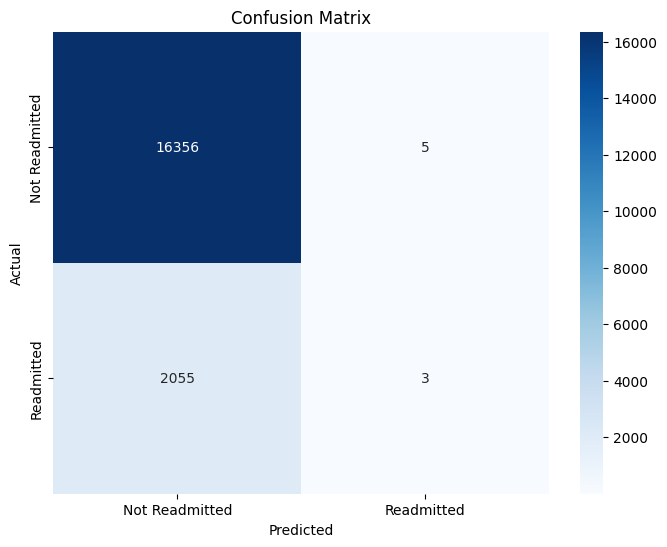

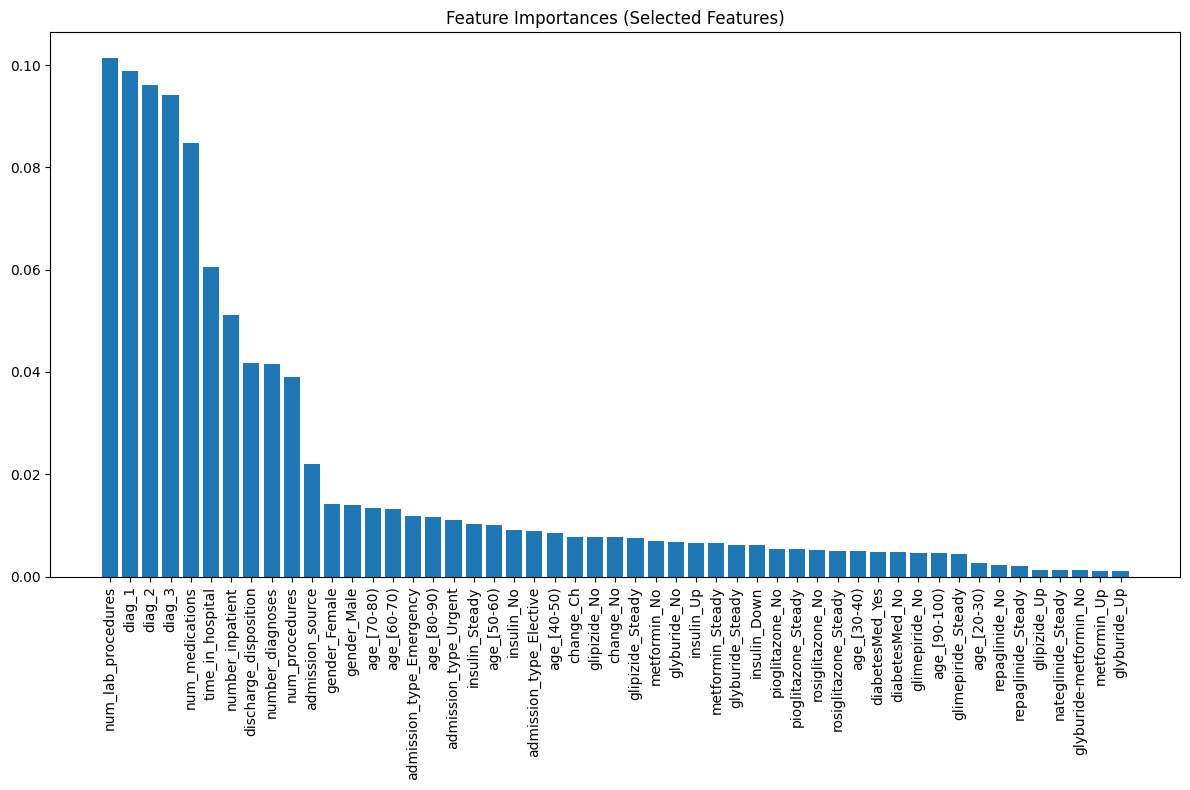


Feature Importances:
time_in_hospital: 0.0605
num_lab_procedures: 0.1013
num_procedures: 0.0391
num_medications: 0.0848
number_inpatient: 0.0512
diag_1: 0.0989
diag_2: 0.0961
diag_3: 0.0941
number_diagnoses: 0.0415
discharge_disposition: 0.0418
admission_source: 0.0221
gender_Female: 0.0142
gender_Male: 0.0140
age_[20-30): 0.0027
age_[30-40): 0.0050
age_[40-50): 0.0085
age_[50-60): 0.0102
age_[60-70): 0.0133
age_[70-80): 0.0135
age_[80-90): 0.0117
age_[90-100): 0.0045
metformin_No: 0.0070
metformin_Steady: 0.0065
metformin_Up: 0.0012
repaglinide_No: 0.0022
repaglinide_Steady: 0.0020
nateglinide_Steady: 0.0013
glimepiride_No: 0.0045
glimepiride_Steady: 0.0044
glipizide_No: 0.0078
glipizide_Steady: 0.0075
glipizide_Up: 0.0013
glyburide_No: 0.0067
glyburide_Steady: 0.0062
glyburide_Up: 0.0011
pioglitazone_No: 0.0054
pioglitazone_Steady: 0.0054
rosiglitazone_No: 0.0051
rosiglitazone_Steady: 0.0051
insulin_Down: 0.0062
insulin_No: 0.0091
insulin_Steady: 0.0102
insulin_Up: 0.0066
glyburide-

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define pipeline with feature selection and classifier
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42, class_weight='balanced'), threshold='median')),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Transform the training and test data with selected features
sfm = pipeline.named_steps['feature_selection']
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[sfm.get_support()]
print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())

# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Get predicted probabilities
y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate and display metrics
def get_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

train_metrics = get_metrics(y_train, y_train_pred, y_train_proba)
test_metrics = get_metrics(y_test, y_test_pred, y_test_proba)

metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Training', 'Test'])
print("\nModel Performance Metrics:")
print(metrics_df)

# Classification report
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importances (after selection)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Selected Features)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature Importances:")
for feature, importance in zip(selected_features, importances):
    print(f"{feature}: {importance:.4f}")






In [30]:
print(df_Of_Diabetic_Data['readmitted'].value_counts())

readmitted
0    81800
1    10292
Name: count, dtype: int64


In [31]:
df_Of_Diabetic_Data.shape

(92092, 102)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

x = df_Of_Diabetic_Data.iloc[:, :-1]
y = df_Of_Diabetic_Data.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=30)

scale = StandardScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 13, 15],
    'weights': ['distance'],
    'metric': ['euclidean']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

best_knn = grid_search.best_estimator_

y_predict = best_knn.predict(x_test_scaled)
print ("KNN Model")
print("Best params: ", grid_search.best_params_)
print("Best cv score: ", grid_search.best_score_)
print("Accuracy: ", best_knn.score(x_test_scaled, y_test))
print("\nConfusion matrix :\n", confusion_matrix(y_test, y_predict))
print("\nClassification Report:\n", classification_report(y_test, y_predict))

KNN Model
Best params:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cv score:  0.9319337616505294
Accuracy:  0.9367755246084101

Confusion matrix :
 [[29763   401]
 [ 1928  4745]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     30164
           1       0.92      0.71      0.80      6673

    accuracy                           0.94     36837
   macro avg       0.93      0.85      0.88     36837
weighted avg       0.94      0.94      0.93     36837



              precision    recall  f1-score   support

           0       0.92      0.61      0.74     16336
           1       0.17      0.61      0.26      2083

    accuracy                           0.61     18419
   macro avg       0.55      0.61      0.50     18419
weighted avg       0.84      0.61      0.68     18419


Top Feature Importances:
                  Feature  Importance
6        number_inpatient    0.311181
11  discharge_disposition    0.245716
7                  diag_1    0.096233
8                  diag_2    0.063142
1      num_lab_procedures    0.042013
3         num_medications    0.036040
9                  diag_3    0.035973
10       number_diagnoses    0.031939
0        time_in_hospital    0.026305
94         diabetesMed_No    0.010729


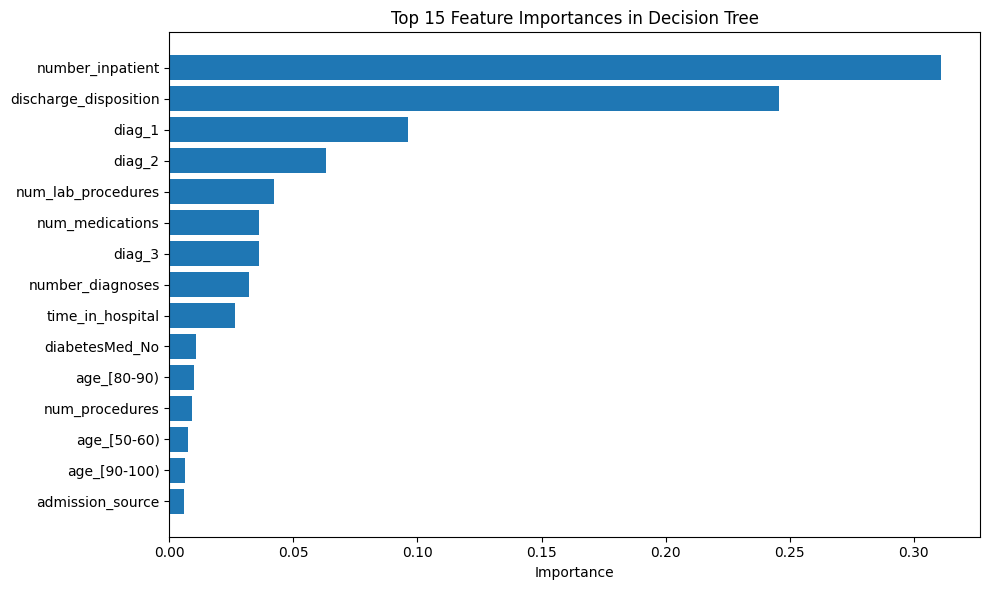

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

X = df_Of_Diabetic_Data.drop('readmitted', axis=1)
y = df_Of_Diabetic_Data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=9, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
importances = clf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Feature Importances:")
print(feature_importance_df.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:15][::-1], feature_importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances in Decision Tree")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:14:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8870348921384104

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     24540
           1       0.39      0.02      0.04      3088

    accuracy                           0.89     27628
   macro avg       0.64      0.51      0.49     27628
weighted avg       0.83      0.89      0.84     27628



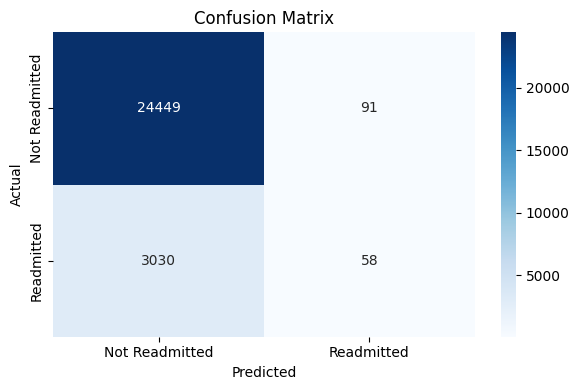

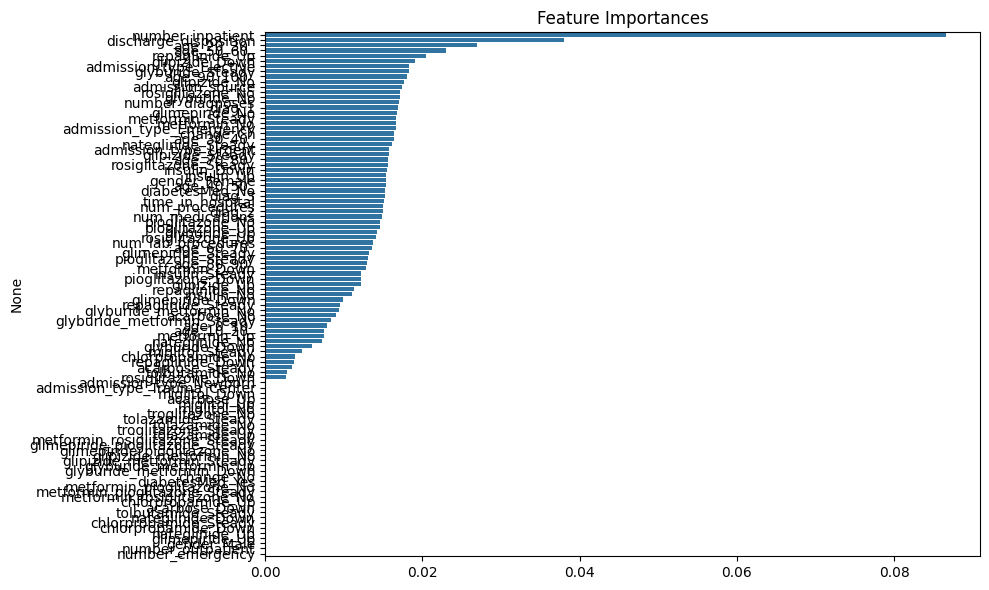

In [34]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Feature and target split
# Clean column names to remove problematic characters
X = df_Of_Diabetic_Data.drop('readmitted', axis=1).copy()
X.columns = X.columns.str.replace('[\[\]<>]', '', regex=True).str.replace('[^0-9a-zA-Z_]', '_', regex=True)

# Target
y = df_Of_Diabetic_Data['readmitted']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train XGBoost model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()
